In [1]:
!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN

events = Events("CheatedRecoFile_0.root")
events2 = Events("CheatedRecoFile_5.root")

ELECTRON_PDG_SET = {11, -11}  # Electron and positron PDG codes
PHOTON_PDG_SET = {22, -22}  # Photon PDG codes
shower_pdg_set = {11, -11, 22, -22} 


In [2]:
def categorise_event(events, event_idx, shower_pdg_set):
    # Extract PDG code
    pdg_code = events.mc_pdg[event_idx]  # Assuming this holds a single PDG code
    
    # Determine if event is a shower or track
    if pdg_code in shower_pdg_set:
        return 'shower'
    else:
        return 'track'  # All other PDG codes are considered as track


def categorise_event_shower(events, event_idx):
    # Extract PDG code
    pdg_code = events.mc_pdg[event_idx]  
    
    # Classify as electron or photon
    if pdg_code in ELECTRON_PDG_SET:
        return 'electron'
    elif pdg_code in PHOTON_PDG_SET:
        return 'photon'
    else:
        return None  # Filter out track particles

def categorise_labels(events, event_idx):
    """
    Categorises events into specific particles: CCnu_e = 3, CCnu_mu = 2, NCnu_x = 0.
    """
    
    if events.is_nue[event_idx]:
        return 2  # Electron
    elif events.is_numu[event_idx]:  
        return 1  # Muon
    elif events.is_cc[event_idx]:
        return 0 # other cc candidates
    else:
        return 0  # Other particles

In [3]:
''' The Features ''' 

# from before 
def correlation(events, event_idx):
    x_hits = events.reco_hits_x_w[event_idx]
    w_hits = events.reco_hits_w[event_idx] 

    # Check if there are valid hits
    if len(w_hits) == len(x_hits) and len(w_hits) > 15: # talk about advantages and disadvantages of results with a threshold 
        if np.std(x_hits) == 0 or np.std(w_hits) == 0:
            return None  # No valid correlation if there's no variation in data
        
        correlation = np.corrcoef(x_hits, w_hits)[0, 1]
        
        # Fit line using w_hits for x and calculate predicted y-values
        line_fit = np.polyfit(w_hits, x_hits, 1)
        line_y_pred = np.polyval(line_fit, w_hits)
        
        # Calculate line error between predicted and actual x_hits
        line_error = np.mean((x_hits - line_y_pred) ** 2)
        
        # Normalize scores
        correlation_score = abs(correlation) if not np.isnan(correlation) else 0
        error_score = max(0, 1 - line_error / 20) if line_error < 20 else 0
        
        # Weighted score
        line_score = (correlation_score * 0.7) + (error_score * 0.3)
        
        return (line_score * 100)  # Return the score and category

    else:
        return None

# from before 

def noise(events, event_idx, eps=2, min_samples=5):
    # Extract hit positions (no PDG filtering, just use reco hits)
    x_hits = events.reco_hits_x_w[event_idx]
    w_hits = events.reco_hits_w[event_idx]

    # Check if there are valid hits
    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
        # Combine the coordinates for clustering
        hits_coordinates = np.column_stack((w_hits, x_hits))

        # Apply DBSCAN clustering
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(hits_coordinates)
        labels = db.labels_

        # Count noise points (labeled as -1)
        n_noise = np.sum(labels == -1)

        # Count clusters (unique labels excluding -1)
        unique_clusters = set(labels) - {-1}
        n_clusters = len(unique_clusters)

        return n_noise + n_clusters
    else:
        return None
def rms(events, event_idx):
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]

    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
        slope, intercept = np.polyfit(w_hits, x_hits, 1)
        
        actual = x_hits
        predicted = slope * w_hits + intercept
        
        meanSquaredError = ((predicted - actual) ** 2).mean()
        return np.sqrt(meanSquaredError)
    else: 
        return None 


import numpy as np

def angle(events, event_idx):
    x_hits = events.reco_hits_x_w[event_idx]
    w_hits = events.reco_hits_w[event_idx]

    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
        # Fit the best-fit line
        line_fit = np.polyfit(w_hits, x_hits, 1)
        line_slope = line_fit[0]
        line_intercept = line_fit[1]

        # Calculate residuals (distance from the line)
        line_y_pred = np.polyval(line_fit, w_hits)
        residuals = np.abs(x_hits - line_y_pred)

        # Find the index of the furthest point
        furthest_idx = np.argmax(residuals)
        furthest_point = np.array([x_hits[furthest_idx], w_hits[furthest_idx]])

        # Start of the line is at the minimum W-coordinate
        min_w = np.min(w_hits)
        start_point = np.array([line_slope * min_w + line_intercept, min_w])

        # End of the red line (best-fit line) at the maximum W-coordinate
        max_w = np.max(w_hits)
        end_of_red_line = np.array([line_slope * max_w + line_intercept, max_w])

        # Calculate the lengths of the three sides of the triangle
        red_line_length = np.linalg.norm(end_of_red_line - start_point)  # Distance between start and end of red line
        purple_line_length = np.linalg.norm(furthest_point - start_point)  # Distance between start and furthest point (purple line)
        third_line_length = np.linalg.norm(furthest_point - end_of_red_line)  # Distance between end of red line and furthest point (third line)

        # Using the cosine rule to calculate the angle between the red and purple lines
        cos_theta = (red_line_length**2 + purple_line_length**2 - third_line_length**2) / (2 * red_line_length * purple_line_length)
        angle_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip value to avoid out-of-bound errors
        angle_degrees = np.degrees(angle_radians)  # Convert radians to degrees
        
        return angle_degrees
    else:
        return None



def line(events, event_idx):
    w_hits = np.array(events.reco_hits_w[event_idx])
    x_hits = np.array(events.reco_hits_x_w[event_idx])

    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
    
        # Calculate differences between consecutive points
        dx = np.diff(w_hits)
        dy = np.diff(x_hits)
    
        # Compute segment lengths
        segment_lengths = np.sqrt(dx**2 + dy**2)
    
        # Total arc length (line integral)
        total_length = np.sum(segment_lengths)
    
        # Normalize by the number of points
        normalised_length = total_length / len(w_hits)

        return normalised_length
    else:
        return None 



def q4(events, event_idx):
    adcs = events.reco_adcs_w[event_idx]

    if len(adcs) > 15:

        q4_idx = len(adcs) // 4

        adcs_q4 = adcs[-q4_idx:]
    
        ratio = sum(adcs_q4) / sum(adcs)
    
    
        return ratio
    else:
       return None



def step_length(events, event_idx):
    # Find all info for the feature
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]
    w_vtx = events.neutrino_vtx_w[event_idx]
    x_vtx = events.neutrino_vtx_x[event_idx]

    # Skip events where there are fewer than 15 hits
    if len(w_hits) < 15:
        return None  # Return None to indicate that the feature should be skipped

    # Finding step length
    w_step = min([abs(w - w_vtx) for w in w_hits])
    x_step = min([abs(x - x_vtx) for x in x_hits])
    step_length = np.sqrt(w_step**2 + x_step**2)

    return step_length






''' The feature code you need to copy '''
# I will mark things you can try and tweak for accuracy in the code with a comment with a brief description of how/why. I won't include ANY other comments.

def find_radial_density_increase(x, y, bins=50, center=None, start_radius=0, debug=False, safety_r=5):
    if center is None:
        center = (np.mean(x), np.mean(y))
    
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    r = r[r > start_radius]
    
    if len(r) == 0:
        return safety_r
    
    r_sorted = np.sort(r)
    
    bin_edges = np.linspace(start_radius, max(r_sorted), bins)
    counts, _ = np.histogram(r_sorted, bins=bin_edges)
    
    areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
    densities = counts / areas
    
    diffs = np.diff(densities)
    increase_idx = np.argmax(diffs > 0)
    
    if increase_idx == 0 and diffs[0] <= 0:
        return safety_r
    
    return bin_edges[increase_idx]


def de_dx(events, event_idx, cone_angle=(5/6)*np.pi, debug=False, show_plot=False): # Put debug=True if you want all debug info, same with show_plot
    w_hits = events.reco_hits_w[event_idx]

    if len(w_hits) <= 15:
        if debug:
            print(f'Event {event_idx} does not meet 15 hit cutoff\n')
        return None

    def debug_print(message):
        if debug:
            print(f"    {message}")
    if debug:
        print(f"Debug for event {event_idx}")
    
    x_hits = events.reco_hits_x_w[event_idx]
    w_vtx = events.neutrino_vtx_w[event_idx]
    x_vtx = events.neutrino_vtx_x[event_idx]
    adcs = events.reco_adcs_w[event_idx]
    
    pdg = events.mc_pdg[event_idx]
    c_class = 'lightblue'
    event = 'ERROR: Not e/gamma'
    if pdg in [-11, 11]:
        c_class = '#EEEE00'
        event = 'Electron'
    elif pdg == 22:
        c_class = 'g'
        event = 'Photon'
    debug_print(f'Lepton: {event}')

    if np.sign(np.mean(w_hits) - w_vtx) == -1:
        w_hits = 2 * w_vtx - np.array(w_hits)
        debug_print(f'Event {event_idx} was left-facing, and has been inverted')

    theta_0 = np.arctan2(np.mean(x_hits) - x_vtx, np.mean(w_hits) - w_vtx)
    theta_u = theta_0 + (cone_angle/2)
    theta_l = theta_0 - (cone_angle/2)
    debug_print(f'Angle info:\n        Yaw = {np.degrees(theta_0):.2f}° from +w\n        Upper Angle = {np.degrees(theta_u):.2f}°\n        Lower Angle: {np.degrees(theta_l):.2f}°')
    
    # You may also want to play around with cone_angle, I don't expect it to have a super huge effect for values > pi/2

    angles = np.arctan2(x_hits - x_vtx, w_hits - w_vtx)
    distance = [np.sqrt((w - w_vtx)**2 + (x - x_vtx)**2) for w, x in zip(w_hits, x_hits)]

    r_start = 5
    if len(distance) >= 5:
        r_start = sorted(distance)[4]
        
    # r_start is arbitrary, just the distance from the event vertex that the radial density algorithm will begin searching, its good for events that start with a cluster and then a gap
    # worth tweaking if you really want to
    
    testing_distance = find_radial_density_increase(w_hits, x_hits, center = (w_vtx, x_vtx), start_radius = r_start)
    branch_distance = max(r_start + 5, testing_distance)
    
    mask = (angles >= theta_l) & (angles <= theta_u) & (distance < branch_distance)
    if mask.sum() == 0:
        print(f'ERROR: Mask is empty for event {event_idx}')
        return None

    points = np.column_stack((w_hits[mask], x_hits[mask]))
    di = np.sqrt(((points[:, None, :] - points[None, :, :]) ** 2).sum(axis=2))
    dx = np.maximum(np.max(di), 0.48)

    val = np.sum(adcs[mask]) / dx
    debug_print(f'dE = {np.sum(adcs[mask])}')
    debug_print(f'dx = {dx}')
    debug_print(f'dE/dx = {val}\n')

    if show_plot:
        w_u = w_vtx + 20 * np.cos(theta_u)
        x_u = x_vtx + 20 * np.sin(theta_u)
        
        w_l = w_vtx + 20 * np.cos(theta_l)
        x_l = x_vtx + 20 * np.sin(theta_l)

        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].scatter(w_vtx, x_vtx, c='r', marker='x', s=35, label='Neutrino vtx')
        ax[0].scatter(w_hits, x_hits, s=3, c=c_class, label=f'{event} Hits')
        ax[0].scatter(np.mean(w_hits), np.mean(x_hits), s=7, facecolor='white', marker='s', edgecolor='r', label='Cone Bisection')
        ax[0].plot([w_vtx, w_u], [x_vtx, x_u], 'b--')
        ax[0].plot([w_vtx, w_l], [x_vtx, x_l], 'b--', label='Angle Bound')
        ax[0].set_title(f'Event Plot; idx: {event_idx}. Event is a {event}')
        ax[0].set_ylabel('X (W View)')
        ax[0].set_xlabel('W (Wire Position)')
        ax[0].legend()
        ax[0].grid(True)

        ax[1].set_title('Display of extracted points via the radial density function')
        ax[1].scatter(w_vtx, x_vtx, c='r', marker='x', s=25, label='Neutrino vtx')
        ax[1].scatter(w_hits, x_hits, s=3, c='grey', label='Hits')
        ax[1].scatter(w_hits[mask], x_hits[mask], s=5, c='purple', label='Identified Points')
        ax[1].legend()
        ax[1].grid(True)

    return val



# Arbitrary booster features, may not be helpful but may work

def adc_sum(events, event_idx):
    adcs = events.reco_adcs_w[event_idx]
    return np.sum(adcs)

def hit_count(events, event_idx, min_hits=15):
    """ Hit_count is to help candidate_lepton it increased the accuracy by around 1.5% """
    # Get all hits for the given event
    all_w_hits = events.reco_hits_w[event_idx]  # Wire plane hits
    all_x_hits = events.reco_hits_x_w[event_idx]  # X-plane hits
    
    # Count total number of hits
    num_hits = len(all_w_hits)  # Assuming same length for both planes

    # Apply filtering: Skip events with fewer than `min_hits`
    if num_hits < min_hits:
        return None  # Not enough hits
    
    return num_hits

from scipy.ndimage import gaussian_filter

def adc_max_pos(events, event_idx, bin_size=8, sigma=2):
    # Extract event data
    w_hits = events.reco_hits_w[event_idx]  # Wire positions

    if len(w_hits) < 15:
        return None
        
    x_hits = events.reco_hits_x_w[event_idx]  # X positions
    adcs = events.reco_adcs_w[event_idx]  # ADC values

    w_vtx = events.neutrino_vtx_w[event_idx]  # Neutrino vertex (wire)
    x_vtx = events.neutrino_vtx_x[event_idx]  # Neutrino vertex (X)

    # Define 2D histogram bins for spatial density estimation
    w_min, w_max = np.min(w_hits), np.max(w_hits)
    x_min, x_max = np.min(x_hits), np.max(x_hits)

    w_bins = np.arange(w_min, w_max + bin_size, bin_size)
    x_bins = np.arange(x_min, x_max + bin_size, bin_size)

    # Compute 2D ADC density histogram
    adc_density, _, _ = np.histogram2d(w_hits, x_hits, bins=[w_bins, x_bins], weights=adcs)

    # Smooth density using a Gaussian filter for better peak detection
    adc_density_smooth = gaussian_filter(adc_density, sigma=sigma)

    # Find bin with maximum ADC density
    max_density_idx = np.unravel_index(np.argmax(adc_density_smooth), adc_density.shape)
    
    # Convert bin indices back to spatial coordinates (center of the bin)
    max_adc_w = w_bins[max_density_idx[0]] + bin_size / 2
    max_adc_x = x_bins[max_density_idx[1]] + bin_size / 2

    # Compute distances
    max_adc_distance = np.sqrt((max_adc_w - w_vtx) ** 2 + (max_adc_x - x_vtx) ** 2)
    max_distance = np.max(np.sqrt((w_hits - w_vtx) ** 2 + (x_hits - x_vtx) ** 2))

    # Compute ratio (normalize by max event distance)
    max_adc_ratio = max_adc_distance / (max_distance + 0.48)  # Avoid division by zero, add the wire spacing.

    return max_adc_ratio

from scipy.spatial import ConvexHull
def hull_density(events, event_idx):
    w_hits = events.reco_hits_w[event_idx] 

    if len(w_hits) < 15:
        return None
        
    x_hits = events.reco_hits_x_w[event_idx]
    points = np.column_stack((w_hits, x_hits))
    
    hull = ConvexHull(points)
    hull_area = hull.volume
    
    hull_density = len(points) / hull_area

    return hull_density


def calculate_features(events, indices):
    """
    Calculate all features for the given event indices.
    """
    features = {
        'correlation': [],
        'noise': [],
        'rms': [],
        'angle': [],
        'line': [],
        'q4': [],
        'step_length': [],
        'de_dx': [],
        'hit_count': [],
        'adc_sum': [],
        'hull_density': []
    }

    for event_idx in indices:
        features['correlation'].append(correlation(events, event_idx))
        features['noise'].append(noise(events, event_idx))
        features['rms'].append(rms(events, event_idx))
        features['angle'].append(angle(events, event_idx))
        features['line'].append(line(events, event_idx))
        features['q4'].append(q4(events, event_idx))
        features['step_length'].append(step_length(events, event_idx))
        features['de_dx'].append(de_dx(events, event_idx))
        features['hit_count'].append(hit_count(events, event_idx))
        features['adc_sum'].append(adc_sum(events, event_idx))
        features['hull_density'].append(hull_density(events, event_idx))
    
    return features

In [4]:
''' With Candidate Lepton '''
# Function to identify candidate leptons in each event
def identify_candidate(events):
    identifiers = events.event_number
    data = np.arange(0, len(events.event_number))
    slices = []
    start_idx = 0

    # Split data into slices based on changes in identifiers
    for i in range(1, len(identifiers)):
        if identifiers[i] != identifiers[i - 1]:
            slices.append(data[start_idx:i])
            start_idx = i  # Update start index for the next slice

    slices.append(data[start_idx:])

    results = []

    for event_number, event_indices in enumerate(slices):  # Enumerate slices to get the event number

        w_hits_event = []
        indices = []  # To keep track of the corresponding `i` values
        
        for i in event_indices:
            w_hits_event.append(events.reco_hits_w[i])
            indices.append(i)  # Store the corresponding `i` values
        
        # Find the index of the maximum length in w_hits_event
        max_idx = max(range(len(w_hits_event)), key=lambda idx: len(w_hits_event[idx]))
        
        # Retrieve the corresponding `i` value
        candidate_idx = indices[max_idx]

        results.append((event_number, candidate_idx))
    
    return results

In [5]:
# Modified `prepare_training_data_softmax` to filter based on identified candidates
def prepare_training_data_softmax(events, candidate_indices):
    """Prepares the feature matrix and labels for training, specifically for electrons and photons."""
    features = []
    labels = []

    for event_idx in candidate_indices:
        # Get features as a dictionary
        features_dict = calculate_features(events, [event_idx])
        
        correlation_score = features_dict['correlation'][0]
        noise_score = features_dict['noise'][0]
        rms_score = features_dict['rms'][0]
        angle_score = features_dict['angle'][0]
        line_score = features_dict['line'][0]
        q4_score = features_dict['q4'][0]
        step_length_score = features_dict['step_length'][0]
        de_dx_score = features_dict['de_dx'][0]
        hit_count_score = features_dict['hit_count'][0]
        adc_sum_score = features_dict['adc_sum'][0]
        hull_density_score = features_dict['hull_density'][0]

        # Replace None values with 0
        feature_row = [correlation_score, noise_score, rms_score, angle_score, line_score, q4_score, 
                       step_length_score, de_dx_score, hit_count_score, adc_sum_score, hull_density_score]
        feature_row = [0 if f is None else f for f in feature_row]

        features.append(feature_row)

        # Get label using the updated categorization function
        labels.append(categorise_labels(events, event_idx))

    return np.array(features), np.array(labels)  # Convert to NumPy arrays

# Use identify_candidate to get candidate indices - IMPORTANT: this is LARGEST hits
candidate_leptons = identify_candidate(events)

# Now extract the candidate indices
candidate_indices = [candidate_idx for event_number, candidate_idx in candidate_leptons]

candidate_leptons2 = identify_candidate(events2)

candidate_indices2 = [candidate_idx for event_number, candidate_idx in candidate_leptons2]

# Generate training and testing data based on identified candidate leptons
x_train, y_train = prepare_training_data_softmax(events, candidate_indices)
x_test, y_test = prepare_training_data_softmax(events2, candidate_indices2)  # Ensure events2 exists


ERROR: Mask is empty for event 386178
ERROR: Mask is empty for event 451408


In [6]:
''' Using XG Boost '''
!pip install xgboost 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.model_selection import train_test_split
# fit model to training data
model = xgb.XGBClassifier()
model.fit(x_train, y_train)


# Make predictions on the test set
y_pred = model.predict(x_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

importances = model.feature_importances_

Accuracy: 71.18%


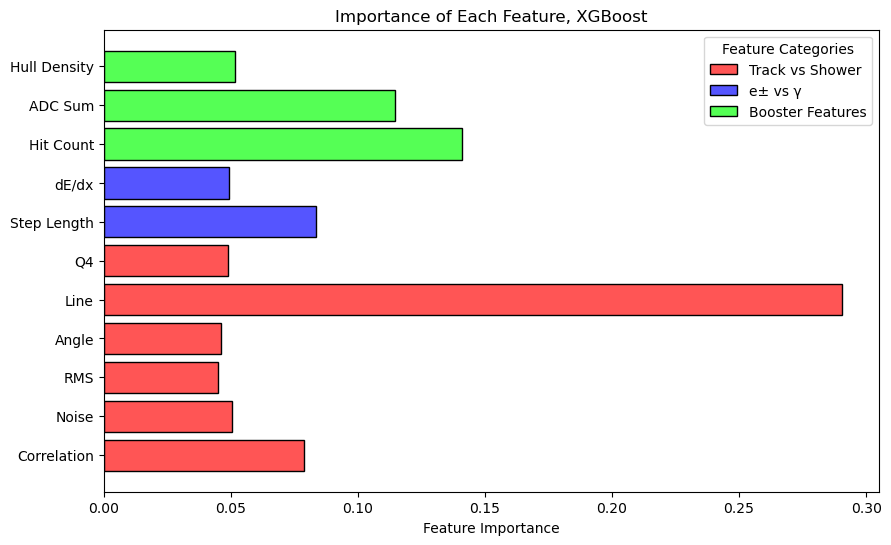

In [7]:
# Feature names and importances
feature_names = ['Correlation', 'Noise', 'RMS', 'Angle', 'Line', 'Q4', 'Step Length', 'dE/dx', 'Hit Count', 'ADC Sum', 'Hull Density']

# Define categories
categories = [
    'Track vs Shower', 'Track vs Shower', 'Track vs Shower', 
    'Track vs Shower', 'Track vs Shower', 'Track vs Shower', 
    'e\u00B1 vs \u03B3', 'e\u00B1 vs \u03B3', 
    'Booster Features', 'Booster Features', 'Booster Features', 'Booster Features'
]

# Assign colors based on categories
colors = {'Track vs Shower': '#F55', 'e\u00B1 vs \u03B3': '#55F', 'Booster Features': '#5F5'}
bar_colors = [colors[cat] for cat in categories]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color=bar_colors, edgecolor='black')
plt.xlabel('Feature Importance')
plt.title('Importance of Each Feature, XGBoost')

# Add legend
legend_labels = {v: k for k, v in colors.items()}  # Reverse mapping
handles = [plt.Rectangle((0, 0), 1, 1, facecolor=c, edgecolor='black') for c in legend_labels]
plt.legend(handles, legend_labels.values(), title='Feature Categories')

plt.show()

ERROR: Mask is empty for event 386178
ERROR: Mask is empty for event 451408
Overall Accuracy: 71.18%


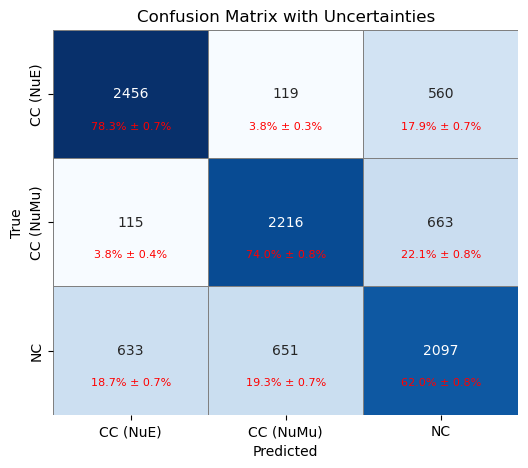

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

def evaluate_candidate_accuracy3f(events, events_unseen):
    # Step 1: Prepare training data
    candidate_leptons_train = identify_candidate(events)  # Get candidate lepton indices for training
    candidate_indices_train = [candidate_idx for event_number, candidate_idx in candidate_leptons_train]
    
    # Prepare the training data
    x_train, y_train = prepare_training_data_softmax(events, candidate_indices_train)
    
    # Step 2: Prepare test data
    candidate_leptons_test = identify_candidate(events_unseen)  # Get candidate lepton indices for testing
    candidate_indices_test = [candidate_idx for event_number, candidate_idx in candidate_leptons_test]
    
    # Prepare the test data
    x_test, y_test = prepare_training_data_softmax(events_unseen, candidate_indices_test)
    
    # Step 3: Train the XGBoost model
    model = xgb.XGBClassifier()
    model.fit(x_train, y_train)
    
    # Step 4: Make predictions
    y_pred = model.predict(x_test)
    
    # Step 5: Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {accuracy:.2%}")
    
    # Step 6: Generate confusion matrix
    labels = ["CC (NuE)", "CC (NuMu)", "NC"]
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[2, 1, 0])  # Muon (0), NC (1: Photon + Other), Electron (2)
    
    df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
    
    # Compute efficiencies in percentage
    bin_efficiencies = (conf_matrix / conf_matrix.sum(axis=1, keepdims=True)) * 100  # Convert to percentage
    
    # Compute binomial uncertainties in percentage
    uncertainties = np.sqrt((bin_efficiencies / 100) * (1 - (bin_efficiencies / 100)) / conf_matrix.sum(axis=1, keepdims=True)) * 100  
    
    # Plot confusion matrix with raw numbers
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
    
    # Annotate with percentages and uncertainties BELOW the numbers in red
    for i in range(len(labels)):
        for j in range(len(labels)):
            total = conf_matrix[i, :].sum()  # Total instances of the actual class
            if total > 0:
                percentage = bin_efficiencies[i, j]
                uncertainty = uncertainties[i, j]
                ax.text(j + 0.5, i + 0.75, f"{percentage:.1f}% ± {uncertainty:.1f}%", ha='center', va='center', fontsize=8, color='red')
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix with Uncertainties")
    plt.show()
    
    return accuracy, conf_matrix, uncertainties

# Evaluate the model on unseen events
accuracy, conf_matrix, uncertainties = evaluate_candidate_accuracy3f(events, events2)

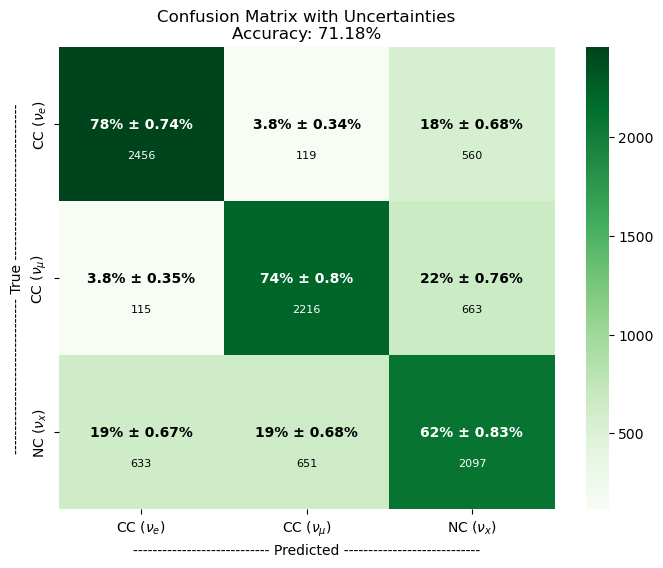

In [12]:
import matplotlib.patheffects as path_effects

labels = [r"CC ($\nu_e$)", r"CC ($\nu_\mu$)", r"NC ($\nu_x$)"]
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# Compute efficiencies in percentage
bin_efficiencies = (conf_matrix / conf_matrix.sum(axis=1, keepdims=True)) * 100  # Convert to percentage

# Compute binomial uncertainties in percentage
uncertainties = np.sqrt((bin_efficiencies / 100) * (1 - (bin_efficiencies / 100)) / conf_matrix.sum(axis=1, keepdims=True)) * 100  

# Plot confusion matrix with raw numbers
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df_cm, annot=False, fmt='d', cmap='Greens', cbar=True)

# Annotate with percentages and uncertainties at the center
for i in range(len(labels)):
    for j in range(len(labels)):
        total = conf_matrix[i, :].sum()  # Total instances of the actual class
        if total > 0:
            percentage = bin_efficiencies[i, j]
            uncertainty = uncertainties[i, j]
            bg_color = conf_matrix[i, j]
            text_color = 'white' if bg_color > 1500 else 'k'
            
            # Centered percentage and uncertainty
            ax.text(j + 0.5, i + 0.5, f"{percentage:.2g}% ± {uncertainty:.2g}%", 
                    ha='center', va='center', fontsize=10, color=text_color, fontweight='bold')

            # Lowered raw count numbers
            ax.text(j + 0.5, i + 0.7, f"{conf_matrix[i, j]}", 
                    ha='center', va='center', fontsize=8, color=text_color)

plt.xlabel("---------------------------- Predicted ----------------------------")
plt.ylabel("-------------------------------- True --------------------------------")
plt.title(f"Confusion Matrix with Uncertainties\nAccuracy: {(100*accuracy):.4g}%")
plt.show()

In [13]:
from sklearn.metrics import classification_report

# Define class labels (ensure they match your confusion matrix order)
labels = [r"CC ($\nu_e$)", r"CC ($\nu_\mu$)", r"NC ($\nu_x$)"]

# Generate report with higher precision (4 significant figures)
report = classification_report(y_test, y_pred, target_names=labels, digits=4)

print(report)

                precision    recall  f1-score   support

  CC ($\nu_e$)     0.6316    0.6202    0.6259      3381
CC ($\nu_\mu$)     0.7421    0.7401    0.7411      2994
  NC ($\nu_x$)     0.7665    0.7834    0.7749      3135

      accuracy                         0.7118      9510
     macro avg     0.7134    0.7146    0.7140      9510
  weighted avg     0.7109    0.7118    0.7113      9510

